# 作业五：偏差和方差

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.optimize as opt

## 1 正则化线性回归
### 1.1 读入数据

(12, 1) (12, 1)
(21, 1) (21, 1)
(21, 1) (21, 1)


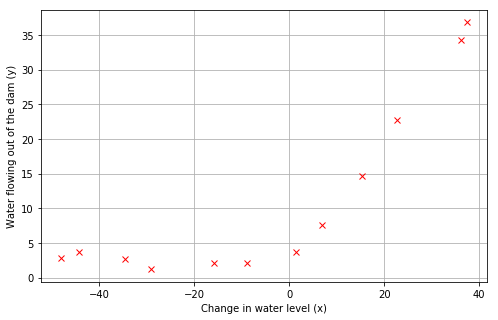

In [3]:
data = loadmat('ex5data1.mat')
X,y,Xtest,ytest,Xval,yval= data['X'],data['y'],data['Xtest'],data['ytest'],data['Xval'],data['yval']

print(X.shape,y.shape)
print(Xtest.shape,ytest.shape)
print(Xval.shape,yval.shape)

fig,ax = plt.subplots(figsize=(8,5))
plt.ylabel('Water flowing out of the dam (y)')
plt.xlabel('Change in water level (x)')
ax.plot(X,y,'rx')
ax.grid(True)

X = np.insert(X,0,1,axis=1)
Xtest = np.insert(Xtest,0,1,axis=1)
Xval = np.insert(Xval,0,1,axis=1)

### 1.2 计算正则化线性回归代价函数及梯度

In [4]:
def computeCost(theta,X,y,lam):
    y = y.flatten()
    m = X.shape[0]
    error = np.dot(X,theta)-y
    cost = 1./(2*m)*np.sum(error**2)
    regu_term = lam/(2*m)*np.sum(theta[1]**2)
    return cost+regu_term

theta = np.ones(X.shape[1])
print(computeCost(theta,X,y,lam=1.))

303.9931922202643


In [5]:
def computeGrad(theta,X,y,lam):
    y = y.flatten()
    m = X.shape[0]
    error = np.dot(X,theta)-y
    grad = np.dot(X.T,error)/m
    regu_grad = lam/m*theta
    regu_grad[0]=0
    return grad+regu_grad
theta = np.ones(X.shape[1])
computeGrad(theta,X,y,lam=1.)

array([-15.30301567, 598.25074417])

### 1.3 拟合线性回归

In [6]:
def optimizeTheta(X, y, lam=0):
    theta = np.ones(X.shape[1])
    optmodel = opt.minimize(fun=computeCost,x0=theta,args=(X, y, lam),method='TNC',jac=computeGrad,options={'disp': True})
    return optmodel.get('x')
final_theta = optimizeTheta(X, y)
print(final_theta)

[13.08790348  0.36777923]


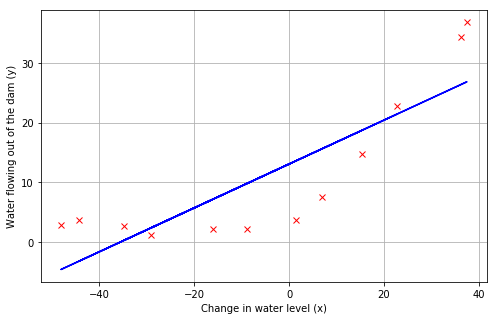

In [7]:
fig,ax = plt.subplots(figsize=(8,5))
plt.ylabel('Water flowing out of the dam (y)')
plt.xlabel('Change in water level (x)')
ax.plot(X[:,1],y,'rx')
ax.plot(X[:,1],np.dot(X,final_theta),'b-')
ax.grid(True)

## 2 方差和偏差

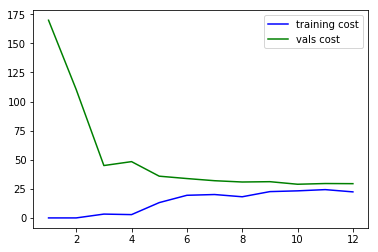

In [8]:
#依次使用训练集的子集来训练模型
#并在验证集上计算代价
train_cost=[]
vals_cost=[]
lam=0
for i in range(1,13):
    Xsub = X[:i, :]
    ysub = y[:i]
    final_theta = optimizeTheta(Xsub,ysub,0)
    train_cost.append(computeCost(final_theta,Xsub, ysub,lam=0))
    vals_cost.append(computeCost(final_theta,Xval, yval,lam=0))
    
plt.plot(np.arange(1, 13), train_cost, 'b-',label='training cost')
plt.plot(np.arange(1, 13), vals_cost,  'g-',label='vals cost')
plt.legend()
plt.show()

## 3 多项式回归
### 3.1 生成多项式特征及归一化特征

In [9]:
def creatPolyFeature(X,power):
    Xploy = X.copy()
    for i in range(power):
        Xploy = np.insert(Xploy,Xploy.shape[1],np.power(Xploy[:,1],i+2),axis=1)
    return Xploy

In [10]:
def normFeature(X):
    Xnorm = X.copy()
    Xnorm_mean = np.mean(X,axis =0)
    Xnorm_std = np.std(X,axis=0)
    Xnorm[:,1:] = (Xnorm[:,1:]-Xnorm_mean[1:])/Xnorm_std[1:]
    return Xnorm,Xnorm_mean,Xnorm_std

### 3.2 多项式回归

In [11]:
X_poly = creatPolyFeature(X,5)##X_poly（12，7）
X_poly,X_poly_mean,X_poly_std = normFeature(X_poly)
final_theta = optimizeTheta(X_poly, y)
print(final_theta)

[ 11.21773525  10.89047071  12.86679848  10.258545    -4.22671468
 -11.38208818  -4.87307813]


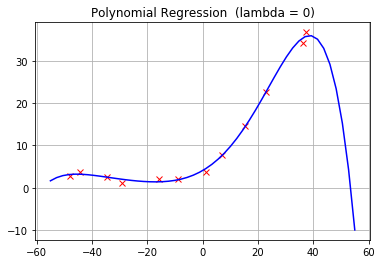

In [12]:
##画出拟合曲线
def plotPolyRegression(X,y,lam=0,power=5):
    X_poly = creatPolyFeature(X,power)
    X_poly,X_poly_mean,X_poly_std = normFeature(X_poly)
    final_theta = optimizeTheta(X_poly, y,lam)
    
    X_plot = np.linspace(-55,55,50).reshape(50,1)
    X_plot = np.insert(X_plot,0,1,axis=1)
    X_plot_poly = creatPolyFeature(X_plot,power)
    X_plot_poly[:,1:] = (X_plot_poly[:,1:] -X_poly_mean[1:])/X_poly_std[1:]

    plt.plot(X[:,1],y,'rx')
    plt.plot(X_plot[:,1],np.dot(X_plot_poly,final_theta),'b-')
    plt.title('Polynomial Regression  (lambda = {})'.format(lam))
    plt.grid(True)
    plt.show()
    
plotPolyRegression(X,y,lam=0)

### 3.3 画出学习曲线

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


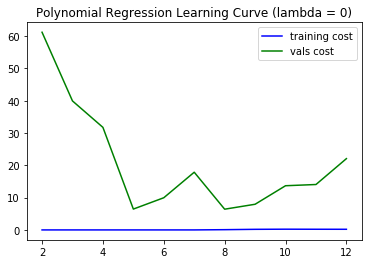

In [14]:
def plotLearningCurve(X,y,Xval,yval,lam=0,power=5):
    train_cost=[]
    vals_cost=[]
    for i in range(1,X.shape[0]+1):
        Xsub = X[:i, :]
        ysub = y[:i]
        #对数据集生成多项式并归一化
        Xsub_poly,Xsub_mean,Xsub_std = normFeature(creatPolyFeature(Xsub,power))
        Xval_poly = creatPolyFeature(Xval,power)
        Xval_poly[:,1:] = (Xval_poly[:,1:]-Xsub_mean[1:])/Xsub_std[1:]
        
        final_theta = optimizeTheta(Xsub_poly, ysub,lam=lam)
        
        train_cost.append(computeCost(final_theta,Xsub_poly, ysub,lam=lam))
        vals_cost.append(computeCost(final_theta,Xval_poly, yval,lam=lam))
    
    plt.plot(np.arange(1, 13), train_cost, 'b-',label='training cost')
    plt.plot(np.arange(1, 13), vals_cost,  'g-',label='vals cost')
    plt.title('Polynomial Regression Learning Curve (lambda = {})'.format(lam))
    plt.legend()
    plt.show()

plotLearningCurve(X,y,Xval,yval,lam=0) 

### 3.4 比较不同$\lambda$值

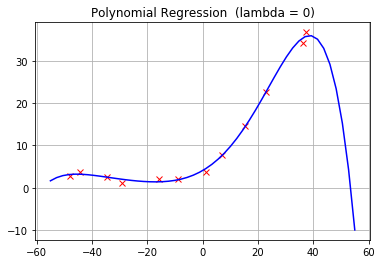

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


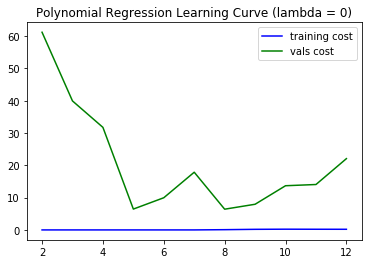

In [15]:
lam=0
power = 5
plotPolyRegression(X,y,lam=lam,power=power)
plotLearningCurve(X,y,Xval,yval,lam=lam,power=power) 
#过拟合

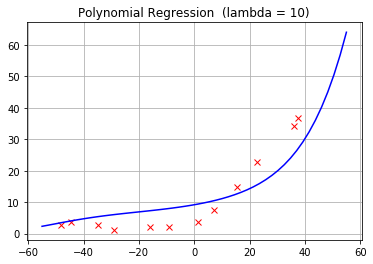

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


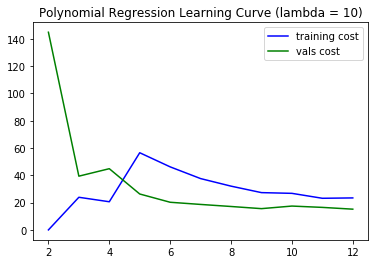

In [16]:
lam=10
power=5
plotPolyRegression(X,y,lam=lam,power=power)
plotLearningCurve(X,y,Xval,yval,lam=lam,power=power) 

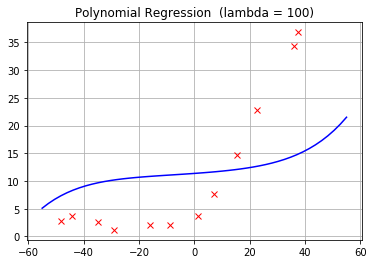

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


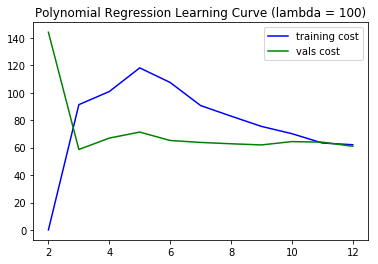

In [290]:
lam=100
power = power
plotPolyRegression(X,y,lam=lam,power=power)
plotLearningCurve(X,y,Xval,yval,lam=lam,power=power) 

### 3.5 找到最佳$\lambda$

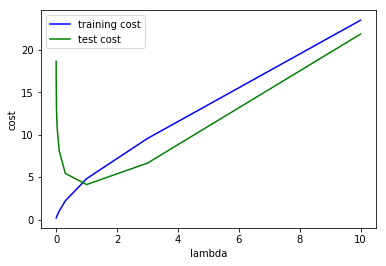

最优lam为 1


In [300]:
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
train_cost=[]
test_cost=[]

X_poly,X_poly_mean,X_poly_std = normFeature(creatPolyFeature(X,5))
Xtest_poly = creatPolyFeature(Xtest,power)
Xtest_poly[:,1:] = (Xtest_poly[:,1:]-X_poly_mean[1:])/X_poly_std[1:]

for lam in l_candidate:

    final_theta = optimizeTheta(X_poly, y,lam = lam)
    
    train_cost.append(computeCost(final_theta,X_poly, y,lam=lam))
    test_cost.append(computeCost(final_theta,Xtest_poly, ytest,lam=lam))
    
plt.plot(l_candidate, train_cost, 'b-',label='training cost')
plt.plot(l_candidate, test_cost,'g-', label='test cost')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('cost')
plt.show()
print('最优lam为',l_candidate[test_cost.index(min(test_cost))])